In [128]:
import pyspark.sql.functions as F

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

**Reading the filtered data**

In [3]:
df_filtered = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_filtered_education_explicit1")

23/03/09 21:38:03 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
df_filtered.count()

3141909

In [5]:
df_filtered.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_filtered.columns]).toPandas().transpose()

,0
coordinates,3140496
created_at,0
display_text_range,3057918
entities,0
extended_entities,3037044
extended_tweet,3141909
favorite_count,0
favorited,0
filter_level,0
geo,3140496


In [6]:
df_filtered.select('user').printSchema()

root
 |-- user: struct (nullable = true)
 |    |-- contributors_enabled: boolean (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- default_profile: boolean (nullable = true)
 |    |-- default_profile_image: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- is_translator: boolean (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- profile_background_color: string (nullable = true)
 |    |-- profile_background_image_url: string (nullable = true)
 |    |-- profile_background_image_url_https: string (nullable = true)
 |    |-- profile_background_tile: 

## Step 2: Which tweet_count to use

In [7]:
pd_df_retweetCounts = df_filtered.select([
    df_filtered.retweet_count,
    df_filtered.quoted_status.retweet_count.alias("quoted_status_retweet_count"),
    df_filtered.retweeted_status.retweet_count.alias("retweeted_status_retweet_count"),
    df_filtered.retweeted_status.reply_count.alias("retweeted_status_reply_count"),
    df_filtered.reply_count.alias("reply_count"),
    df_filtered.tweet_text
]).limit(10000).toPandas()

In [8]:
pd_df_retweetCounts.describe()

,retweet_count,quoted_status_retweet_count,retweeted_status_retweet_count,retweeted_status_reply_count,reply_count
count,10000.0,713.000000,9376.000000,9376.000000,10000.0
mean,0.0,2223.826087,2083.953072,205.861241,0.0
std,0.0,6073.120568,6394.549286,786.133547,0.0
min,0.0,0.000000,1.000000,0.000000,0.0
25%,0.0,13.000000,7.000000,1.000000,0.0
50%,0.0,208.000000,90.000000,10.000000,0.0
75%,0.0,1528.000000,1025.250000,92.000000,0.0
max,0.0,98252.000000,55663.000000,24481.000000,0.0


## Step 3: Which location to use

In [9]:
df_filtered.select('place').printSchema()

root
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- full_name: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |    |-- url: string (nullable = true)



In [16]:
pd_df_geodata = df_filtered.select([
    df_filtered.coordinates,
    df_filtered.geo.coordinates.alias("geo_coordinates"),
    df_filtered.place,
    df_filtered.user.location.alias("user__location")
]).limit(10000).toPandas()

In [17]:
pd_df_geodata.describe()

,coordinates,geo_coordinates,place,user__location
count,4,4,18,10000
unique,4,4,17,5726
top,"([-97.8241043, 30.397078], Point)","[30.397078, -97.8241043]","(([[[-85.605166, 30.355644], [-85.605166, 35.0...",United States
freq,1,1,2,177


In [18]:
df = df_filtered.select([
    df_filtered.id,
    df_filtered.created_at,
    df_filtered.user['name'].alias('user_name'),
    df_filtered.user.description.alias('user_description'),
    df_filtered.user.verified.alias('verified_status'),
    df_filtered.user.location.alias('user_location'),
    df_filtered.user.followers_count.alias('followers_count'),
    df_filtered.user.geo_enabled.alias('geo_enabled'),
    df_filtered.user.id_str.alias('user_id_str'),
    df_filtered.user.id.alias('user_id'),
    df_filtered.tweet_text,
    df_filtered.text,
    df_filtered.retweeted_status['retweet_count'].alias('retweet_count'),
    df_filtered.retweeted_status,
    df_filtered.geo,
    df_filtered.stripped
])

In [21]:
pd_null_counts = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).toPandas().transpose()

23/03/10 02:02:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 35 for reason Container marked as failed: container_1678345426140_0013_01_000035 on host: hub-msca-bdp-dphub-students-harshamuthukuru-sw-3spp.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/03/10 02:02:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 36 for reason Container marked as failed: container_1678345426140_0013_01_000036 on host: hub-msca-bdp-dphub-students-harshamuthukuru-sw-3spp.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/03/10 02:02:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 32 for reason Container marked as failed: container_1678345426140_0013_01_000032 on host: hub-msca-bd

In [48]:
pd_null_counts1 = pd_null_counts.rename(columns = {0:'null_counts'})

In [30]:
pd_null_counts1['percentages'] = (pd_null_counts1['null_counts']/3141909)*100

In [31]:
pd_null_counts1

,null_counts,percentages
id,0,0.000000
created_at,0,0.000000
user_name,0,0.000000
user_description,252250,8.028558
verified_status,0,0.000000
user_location,0,0.000000
followers_count,0,0.000000
geo_enabled,0,0.000000
user_id_str,0,0.000000
user_id,0,0.000000


In [50]:
print('Count of Retweets: ',3141909-204841)
print('Count of original tweets',204841)

Count of Retweets:  2937068
Count of original tweets 204841


Text(0, 0.5, 'Percentage')

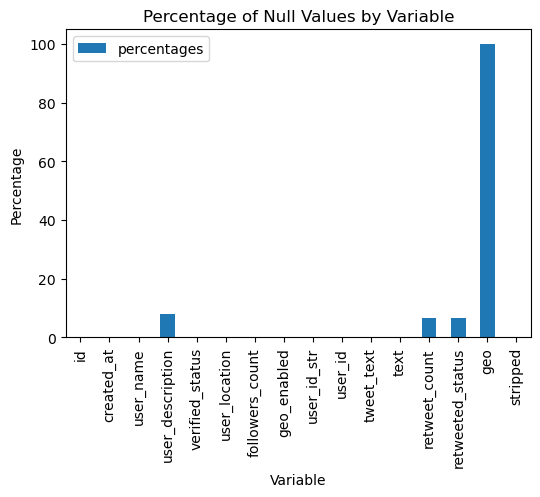

In [40]:
# create a bar plot of the percentages
ax = pd_null_counts1.plot(kind='bar', y='percentages', figsize=(6,4))
ax.set_title('Percentage of Null Values by Variable')
ax.set_xlabel('Variable')
ax.set_ylabel('Percentage')

**Taking the sample of 1000 records**

In [41]:
pd_df_most_tweeted_tweets = df_filtered.groupBy('stripped').agg(F.count('id').alias('count')).orderBy('count', ascending=False).limit(10).toPandas()

In [46]:
import pandas as pd

In [47]:
pd.set_option('display.max_colwidth', 1000)
pd_df_most_tweeted_tweets.head()

,stripped,count
0,if you are okay with having muslim jewish and hindu students sit through a christian prayer in public school and not okay with having christian students sit through a muslim jewish or hindu prayer then it’s not religious freedom- it’s religious oppression,18699
1,i went to law school because my dad was sentenced to life in prison for non-violent drug crimes i did what i could to get him out he did 20 years and got out right in time for my graduation,11653
2,average weekly wages\n1973: 873\n2022: 813\n\nmedian home\n1973: 30200\n2022: 433100\n\nmonthly rent\n1973: 108\n2022: 2002\n\ntuition and fees at university of california\n1973: 150\n2022: 13104\n\nboomer: but why cant the slackers pay for college amp pay off their loans like we did?,10907
3,in 2006 a high school english teacher asked students to write to a famous author amp ask for advice\n\nkurt vonnegut was the only one to respond\n\nhis reply was a doozy,10358
4,just because a student does not raise their hand does not mean that they are not thinking deeply about the content we need to broaden what we mean by engagement in our classrooms/schools this will invite/value more students in the learning process,9608


In [51]:
df_sample = df.limit(1000).cache()

In [52]:
df_sample.limit(1)

id,created_at,user_name,user_description,verified_status,user_location,followers_count,geo_enabled,user_id_str,user_id,tweet_text,text,retweet_count,retweeted_status,geo,stripped
1554487268446015490,Tue Aug 02 15:20:...,StrongerTMU,Toronto Metropoli...,false,TorontoMetU - Tor...,625,false,1920532658,1920532658,in a conversation...,RT @thecreativesc...,3,"{null, Wed Jul 27...",null,in a conversation...


In [53]:
df_sample.select('geo').printSchema()

root
 |-- geo: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)



In [54]:
df_orginal_tweets = df.filter('retweeted_status is null and verified_status == True')

In [96]:
df_original = df_orginal_tweets.groupBy('user_name')\
                               .agg(F.count('*').alias('tweet_count'))\
                               .orderBy('tweet_count', ascending = False)

In [100]:
df_original.count()

4348

In [97]:
pd_df_original = df_original.limit(30).toPandas()

In [98]:
pd_df_original.head()

,user_name,tweet_count
0,Jim Dickinson,88
1,Hindustan Times,47
2,Science Careers,43
3,U.S. News Education,42
4,Fox News,41


**Tweet vs Retweet distribution**

In [99]:
df_sample.select('retweet_count', 'tweet_text').show(10)

+-------------+--------------------+
|retweet_count|          tweet_text|
+-------------+--------------------+
|            3|in a conversation...|
|           17|no, students dese...|
|            2|@wakefieldmiddle ...|
|          357|some news : i am ...|
|            2|will swaim, found...|
|           52|‘hindu on campus’...|
|          424|people in baltimo...|
|           83|in up, there is a...|
|         null|when is your firs...|
|          539|as the up college...|
+-------------+--------------------+
only showing top 10 rows



In [59]:
df_retweeted_tweets = df.filter('retweeted_status is not null')

In [129]:
df_avg_retweets = df_retweeted_tweets.groupby(['user_name'])\
                            .agg((F.avg('retweet_count')).alias('average_retweets'),F.sum('retweet_count').alias('sum_retweets') )

In [130]:
df_avg_retweets.limit(5)

user_name,average_retweets,sum_retweets
Vote Blue In 2022,27.0,54
William Haughton,3488.6666666666665,10466
IU PsychBrain,2.0,2
Tamisha Williams ...,14.5,29
G°ds°n OpPa ™🇳🇬...,366.5,3665


In [131]:
df_retweets_per_tweet = df_original.join(df_avg_retweets, 'user_name',"left")

In [132]:
df_retweets_per_tweet.limit(5)

user_name,tweet_count,average_retweets,sum_retweets
#GenerationalThin...,2,2.3333333333333335,7
106 KMEL,1,null,null
12 News,1,null,null
13WHAM,1,1.0,1
2GB Sydney,1,null,null


In [133]:
pd_df_retweets_per_tweet = df_retweets_per_tweet.limit(10000).toPandas()

In [134]:
pd_df_retweets_per_tweet.shape

(4348, 4)

In [136]:
pd_df_retweets_per_tweet.sort_values('tweet_count', ascending=False).head()

,user_name,tweet_count,average_retweets,sum_retweets
1745,Jim Dickinson,88,25.941176,441.0
2526,Hindustan Times,47,1.037037,56.0
480,Science Careers,43,12.500000,50.0
4216,U.S. News Education,42,6.500000,13.0
2428,Fox News,41,1.000000,1.0


In [25]:
import matplotlib.pyplot as plt

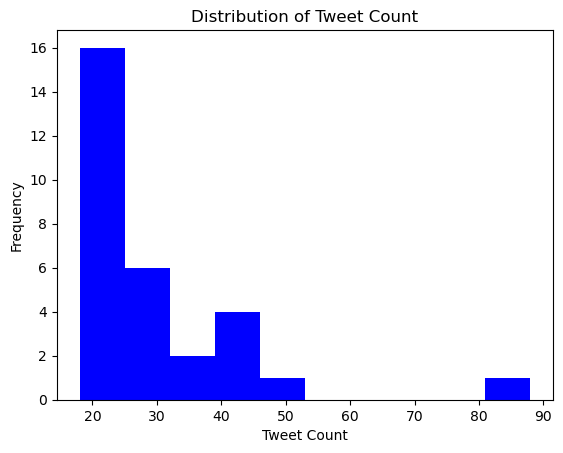

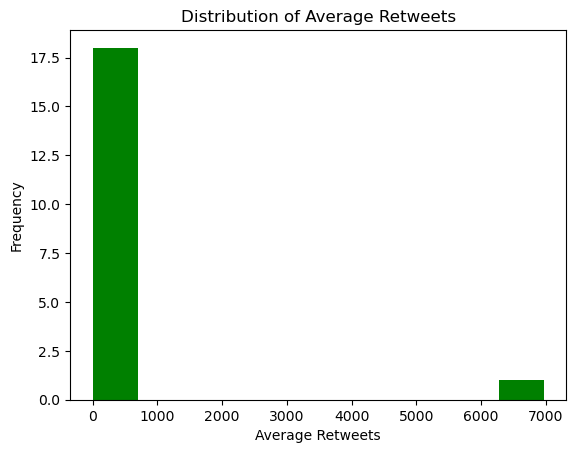

In [26]:
# create the histogram plot for tweet_count
plt.hist(pd_df_retweets_per_tweet['tweet_count'], bins=10, color = 'blue')

# add title and axis labels
plt.title("Distribution of Tweet Count")
plt.xlabel("Tweet Count")
plt.ylabel("Frequency")

# show the plot
plt.show()

# create the histogram plot for average_retweets
plt.hist(pd_df_retweets_per_tweet['average_retweets'], bins=10, color = 'green')

# add title and axis labels
plt.title("Distribution of Average Retweets")
plt.xlabel("Average Retweets")
plt.ylabel("Frequency")

# show the plot
plt.show()

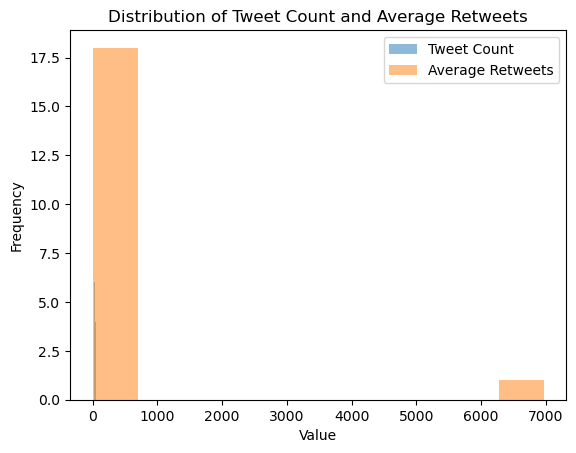

In [27]:
# create the histogram plot for both tweet_count and average_retweets
plt.hist(pd_df_retweets_per_tweet['tweet_count'], bins=10, alpha=0.5, label='Tweet Count')
plt.hist(pd_df_retweets_per_tweet['average_retweets'], bins=10, alpha=0.5, label='Average Retweets')

# add title and axis labels
plt.title("Distribution of Tweet Count and Average Retweets")
plt.xlabel("Value")
plt.ylabel("Frequency")

# add legend
plt.legend(loc='upper right')

# show the plot
plt.show()

### Twitteres categorization

**Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?**

Example description from a verified profile

The #1 source for celebrity news and inspiring stories. ✨ Listen to PEOPLE Every Day for the latest news in pop culture: http://peoplem.ag/3ferrDz

Based on the description choosing keywords to categorize the twitterers

In [67]:
government_entities = ['government', 'agency', 'ministry', 'bureau', 
                       'administration', 'commission', 'council', 'embassy', 'consulate']

In [68]:
government_entities_regex = '|'.join(["(" + c +")" for c in government_entities])

In [69]:
universities = ['university', 'college', 'academy', 'institute', 'campus', 
                'research', 'department', 'program', 'alumni', 'degree',]

In [70]:
universities_regex = '|'.join(["(" + c + ")" for c in universities])

In [71]:
schools = [
           'school', 'academy', 'institute', 'campus', 'education', 'teacher', 'student', 'parent', 
           'principal', 'superintendent', 'district', 'classroom', 'learning', 'curriculum', 'education reform']

In [72]:
schools_regex = '|'.join(["(" + c + ")" for c in schools])

In [73]:
nonprofit_organizations = ['nonprofit', 'charity', 'foundation', 'ngo', 'social justice', 
                           'advocacy', 'philanthropy', 'volunteer', 'donation',
                           'support', 'human rights', 'environment']

In [74]:
nonprofit_organizations_regex = '|'.join(["(" + c + ")" for c in nonprofit_organizations])

In [75]:
news_outlets = ['news', 'media', 'journalism', 'newspaper', 'magazine', 'editor', 'reporter',
                'breaking news', 'current events', 'world news', 'local news', 'national news', 
                'international news', 'broadcast', 'daily']

In [76]:
news_outlets_regex = '|'.join(["(" + c + ")" for c in news_outlets])

In [77]:
# social_media_influencers = ['influencer', 'social media', 'lifestyle', 'fashion', 'beauty', 
#                             'foodie', 'travel', 'fitness', 'health', 'wellness', 'blogger', 'vlogger', 
#                             'content creator', 'brand ambassador', 'sponsored']

In [78]:
# social_media_influencers_regex = '|'.join(["(" + c + ")" for c in social_media_influencers])

In [79]:
for col in df_sample.columns:
    print(col)

id
created_at
user_name
user_description
verified_status
user_location
followers_count
geo_enabled
user_id_str
user_id
tweet_text
text
retweet_count
retweeted_status
geo
stripped


In [80]:
df_lower_user_name_description = df.withColumn("user_name_lower",F.lower(F.col('user_name')))\
                                    .withColumn("user_description_lower", F.lower(F.col('user_description')))

In [81]:
df_lower_user_name_description.select('verified_status').printSchema()

root
 |-- verified_status: boolean (nullable = true)



In [82]:
df_categorize_twitteres = df_lower_user_name_description\
                          .withColumn("organization", F.when((df['followers_count'] < 1000), 'Others')\
                                      .when((df_lower_user_name_description['user_name_lower'].rlike(news_outlets_regex)) | (df_lower_user_name_description['user_description_lower'].rlike(news_outlets_regex)), 'News')\
                                      .when((df_lower_user_name_description['user_name_lower'].rlike(government_entities_regex)) | (df_lower_user_name_description['user_description_lower'].rlike(government_entities_regex)), 'Government')\
                                      .when((df_lower_user_name_description['user_name_lower'].rlike(nonprofit_organizations_regex)) | (df_lower_user_name_description['user_description_lower'].rlike(nonprofit_organizations_regex)), 'NGO')\
                                      .when((df_lower_user_name_description['user_name_lower'].rlike(universities_regex)) | (df_lower_user_name_description['user_description_lower'].rlike(universities_regex)), 'Universities')\
                                      .when((df_lower_user_name_description['user_name_lower'].rlike(schools_regex)) | (df_lower_user_name_description['user_description_lower'].rlike(schools_regex)), 'Schools')\
                                      .when((df_lower_user_name_description['verified_status'] == True) | (df_lower_user_name_description['followers_count'] > 10000), 'Influencers')          
                                      .otherwise('Others')        
).drop('user_name_lower', 'user_description_lower')

In [101]:
df_user_org_type = df_categorize_twitteres.select('user_name', 'organization').\
                    groupBy('user_name').agg(F.first('organization').alias('organization'))

In [102]:
df_user_org_type.limit(5)

user_name,organization
ANTHONIO DE' GR8,Others
Engr Iftikhar kamal,Others
TEAM SLAMOLA,Others
William White,Others
! AM,Others


In [83]:
pd_sample_organization_count = df_categorize_twitteres.select('user_name', 'organization', 'user_description').limit(10).cache().toPandas()

In [ ]:
pd_df_retweets_per_tweet

In [140]:
df_original_twitteres_organization_retweets = df_retweets_per_tweet.join(df_user_org_type, 'user_name', 'left' )

In [ ]:
pd_df_original_twitteres_org_count = df_original_twitteres_organization.groupBy('organization').\
                                    agg(F.count('user_name').alias('count_original_content_twitterers')).toPandas()

In [108]:
df_original_twitteres_organization = df_original.join(df_user_org_type, 'user_name', 'left' )

In [112]:
pd_df_original_twitteres_org_count = df_original_twitteres_organization.groupBy('organization').\
                                    agg(F.count('user_name').alias('count_original_content_twitterers')).toPandas()

In [137]:
pd_df_twitterer_original_tweet_count = df_original_twitteres_organization.groupBy('organization').\
                                    agg(F.sum('tweet_count').alias('tweet_count')).toPandas()

In [162]:
pd_df_twitterer_original_tweet_count['tweet_percentage'] = (pd_df_twitterer_original_tweet_count['tweet_count']/pd_df_twitterer_original_tweet_count['tweet_count'].sum())*100

In [163]:
pd_df_twitterer_original_tweet_count.dtypes

organization         object
tweet_count           int64
percentage          float64
tweet_percentage    float64
dtype: object

In [164]:
pd_df_twitterer_original_tweet_count['tweet_percentage'] = pd_df_twitterer_original_tweet_count['tweet_percentage'].apply(lambda x: round(x, 2))

In [165]:
pd_df_twitterer_original_tweet_count

,organization,tweet_count,percentage,tweet_percentage
0,Government,120,1.32,1.32
1,NGO,149,1.64,1.64
2,Influencers,2055,22.60,22.60
3,Others,304,3.34,3.34
4,Schools,291,3.20,3.20
5,Universities,347,3.82,3.82
6,News,5826,64.08,64.08


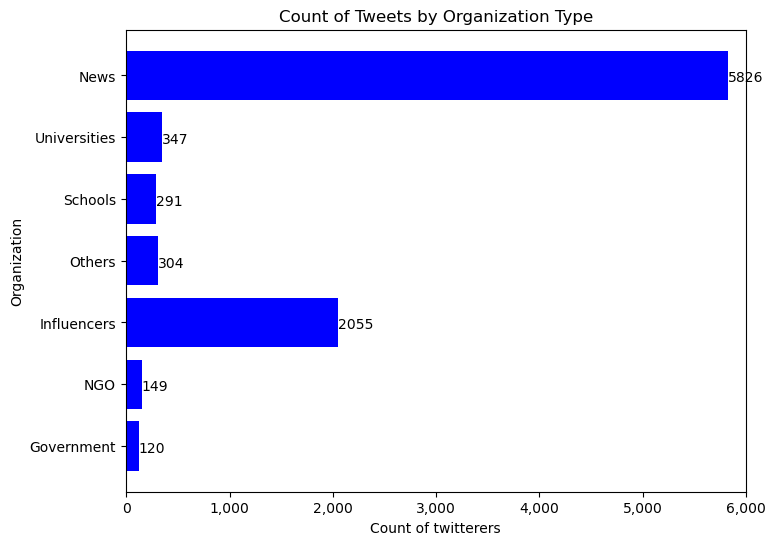

In [146]:
fig, ax = plt.subplots(figsize = (8,6))
ax.barh(pd_df_twitterer_original_tweet_count['organization'], pd_df_twitterer_original_tweet_count['tweet_count'], color='blue')
ax.set_xlabel('Count of twitterers')
ax.set_ylabel('Organization')
ax.set_title('Count of Tweets by Organization Type')
plt.xlim([-5, 6000])
for i, v in enumerate(pd_df_twitterer_original_tweet_count['tweet_count']):
    plt.text(v, i - 0.1, str(v), color='black')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.xaxis.set_major_formatter(formatter)
plt.show()

In [ ]:
pd_df_twitterer_original_retweet_count = df_original_twitteres_organization_retweets.groupBy('organization').\
                                    agg(F.sum('sum_retweets').alias('retweets_count')).toPandas()

In [143]:
pd_df_twitterer_original_retweet_count

,organization,retweets_count
0,Government,34227
1,NGO,126147
2,Influencers,935450
3,Others,6664830
4,Schools,101500
5,Universities,475809
6,News,932875


In [166]:
pd_df_twitterer_original_retweet_count['retweet_percentage'] = (pd_df_twitterer_original_retweet_count['retweets_count']/pd_df_twitterer_original_retweet_count['retweets_count'].sum())*100

In [167]:
pd_df_twitterer_original_retweet_count['retweet_percentage'] = pd_df_twitterer_original_retweet_count['retweet_percentage'].apply(lambda x: round(x, 2))

In [168]:
pd_df_twitterer_original_retweet_count

,organization,retweets_count,percentage,retweet_percentage
0,Government,34227,0.37,0.37
1,NGO,126147,1.36,1.36
2,Influencers,935450,10.09,10.09
3,Others,6664830,71.89,71.89
4,Schools,101500,1.09,1.09
5,Universities,475809,5.13,5.13
6,News,932875,10.06,10.06


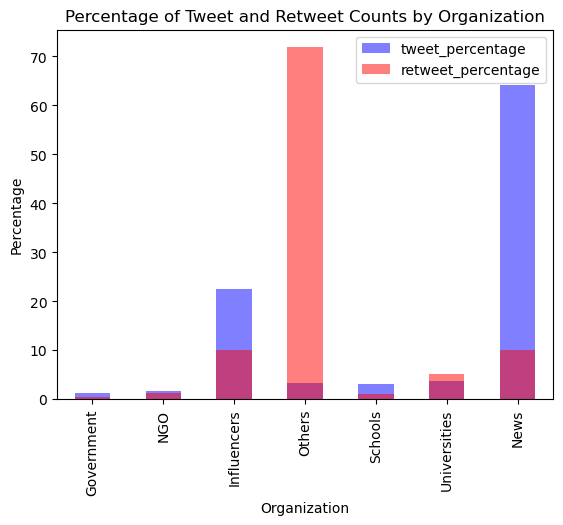

In [170]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the dataframes
pd_df_twitterer_original_tweet_count.plot(kind='bar', x='organization', y='tweet_percentage', ax=ax, color='blue', alpha=0.5)
pd_df_twitterer_original_retweet_count.plot(kind='bar', x='organization', y='retweet_percentage', ax=ax, color='red', alpha=0.5)

# Set the title and labels
ax.set_title('Percentage of Tweet and Retweet Counts by Organization')
ax.set_xlabel('Organization')
ax.set_ylabel('Percentage')

# Show the plot
plt.show()

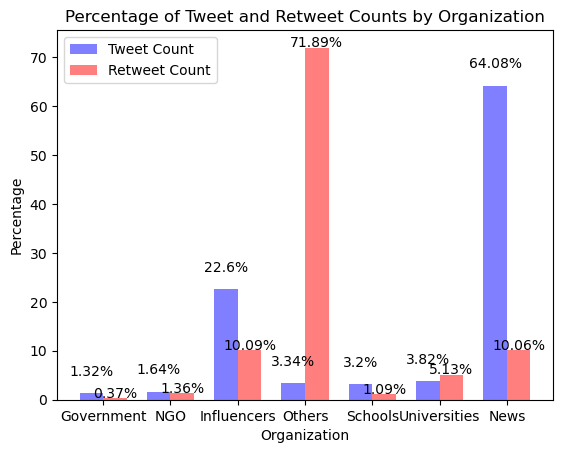

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Set the x-axis locations
x = np.arange(len(pd_df_twitterer_original_tweet_count['organization']))

# Set the width of the bars
bar_width = 0.35

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the tweet count percentages
ax.bar(x - bar_width/2, pd_df_twitterer_original_tweet_count['tweet_percentage'], width=bar_width, label='Tweet Count', color='blue', alpha=0.5)

# Plot the retweet count percentages
ax.bar(x + bar_width/2, pd_df_twitterer_original_retweet_count['retweet_percentage'], width=bar_width, label='Retweet Count', color='red', alpha=0.5)

# Set the x-axis tick labels to the organization names
ax.set_xticks(x)
ax.set_xticklabels(pd_df_twitterer_original_tweet_count['organization'])

# Set the title and labels
ax.set_title('Percentage of Tweet and Retweet Counts by Organization')
ax.set_xlabel('Organization')
ax.set_ylabel('Percentage')

# Add text labels to each bar
for i in range(len(pd_df_twitterer_original_tweet_count)):
    ax.text(x[i] - bar_width/2, pd_df_twitterer_original_tweet_count['percentage'][i]+3, str(pd_df_twitterer_original_tweet_count['percentage'][i]) + '%', ha='center', va='bottom')
    ax.text(x[i] + bar_width/2, pd_df_twitterer_original_retweet_count['percentage'][i]-0.5, str(pd_df_twitterer_original_retweet_count['percentage'][i]) + '%', ha='center', va='bottom')

# Add a legend
ax.legend(loc='upper left')


# Show the plot
plt.show()


In [ ]:
pd_df_twitterer_original_retweet_count = df_original_twitteres_organization.groupBy('organization').\
                                    agg(F.sum('tweet_count').alias('tweet_count')).toPandas()

In [121]:
pd_df_original_twitteres_org_count.sort_values('count_original_content_twitterers', ascending=False, inplace=True)

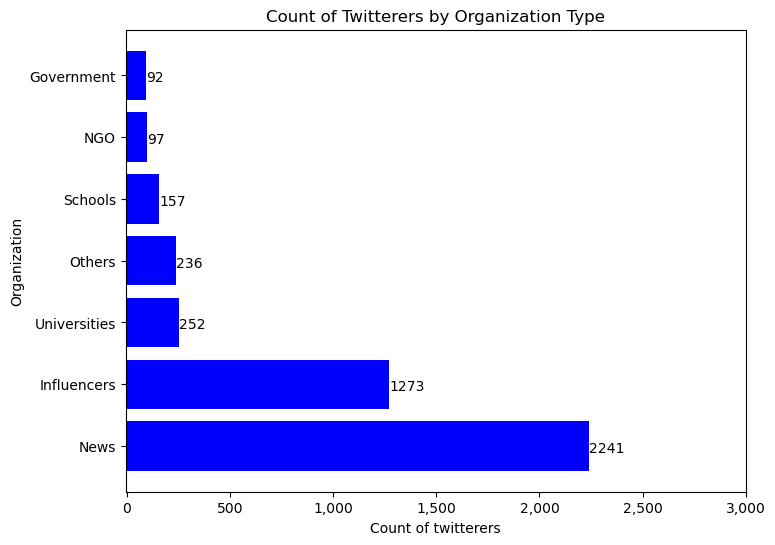

In [124]:
fig, ax = plt.subplots(figsize = (8,6))
ax.barh(pd_df_original_twitteres_org_count['organization'], pd_df_original_twitteres_org_count['count_original_content_twitterers'], color='blue')
ax.set_xlabel('Count of twitterers')
ax.set_ylabel('Organization')
ax.set_title('Count of Twitterers by Organization Type')
plt.xlim([-5, 3000])
for i, v in enumerate(pd_df_original_twitteres_org_count['count_original_content_twitterers']):
    plt.text(v, i - 0.1, str(v), color='black')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.xaxis.set_major_formatter(formatter)
plt.show()

In [84]:
pd_sample_organization_count.head()

,user_name,organization,user_description
0,StrongerTMU,Others,Toronto Metropolitan University (formerly Ryerson University) is building on 74 years of excellence and achievement. Join us and shape the future.
1,Pravin Jeya,Others,"PhD in Environmental Law, communications officer and data analyst. Right-leaning on some issues, left-leaning on others. #BackingBadenoch"
2,Wakefield Strong,Others,A Twitter to unite all 3 Wakefield Schools so our community can keep up with all things Wakefield!
3,Krishna Suma Sreedharan,Others,What is left for a virus to kill in a morally corrupt nation? 🏳️‍🌈
4,FTW,Others,None


In [85]:
pd_organization_tweet_count = df_categorize_twitteres.groupBy('Organization').agg(F.count('id').alias('count')).toPandas()

In [86]:
pd_organization_tweet_count = pd_organization_tweet_count.sort_values('count', ascending=False)

In [87]:
pd_organization_tweet_count

,Organization,count
3,Others,2654684
2,Influencers,118583
4,Schools,109580
6,News,98534
5,Universities,74585
1,NGO,66962
0,Government,18981


In [88]:
pd_org_retweets = df_categorize_twitteres.groupBy('Organization').agg(F.avg('retweet_count').alias('avg_retweets')).toPandas()

In [89]:
pd_org_retweets = pd_org_retweets.sort_values('avg_retweets', ascending=False).round()

In [90]:
pd_org_retweets

,Organization,avg_retweets
3,Others,2220.0
2,Influencers,1040.0
1,NGO,1034.0
0,Government,804.0
6,News,782.0
4,Schools,622.0
5,Universities,607.0


In [91]:
import pandas as pd

In [92]:
import matplotlib.pyplot as plt

In [93]:
import matplotlib.ticker as ticker

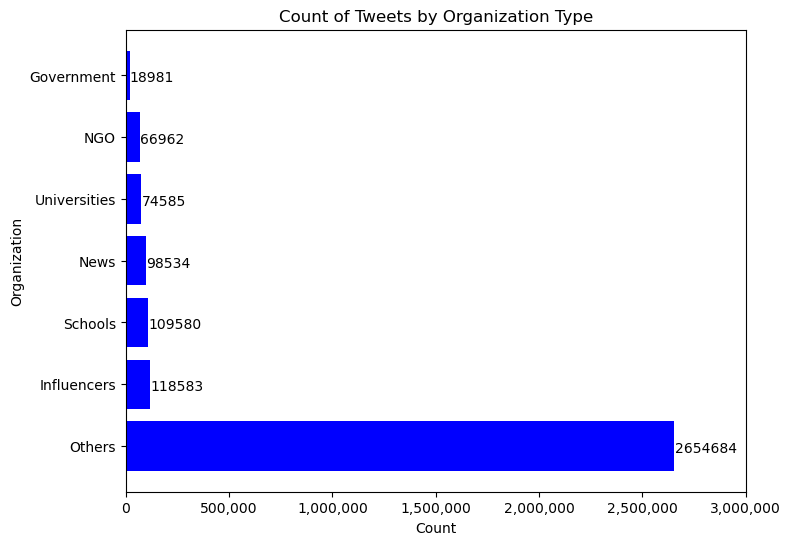

In [127]:
fig, ax = plt.subplots(figsize = (8,6))
ax.barh(pd_organization_tweet_count['Organization'], pd_organization_tweet_count['count'], color='blue')
ax.set_xlabel('Count')
ax.set_ylabel('Organization')
ax.set_title('Count of Tweets by Organization Type')
plt.xlim([-5, 3000000])
for i, v in enumerate(pd_organization_tweet_count['count']):
    plt.text(v + 1000, i - 0.1, str(v), color='black')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.xaxis.set_major_formatter(formatter)
plt.show()

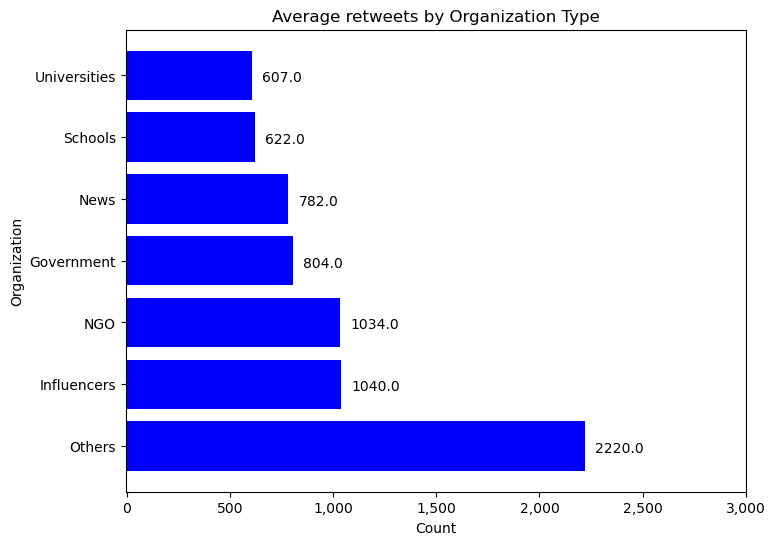

In [126]:
fig, ax = plt.subplots(figsize = (8,6))
ax.barh(pd_org_retweets['Organization'], pd_org_retweets['avg_retweets'], color='blue')
ax.set_xlabel('Count')
ax.set_ylabel('Organization')
ax.set_title('Average retweets by Organization Type')
plt.xlim([-5, 3000])
for i, v in enumerate(pd_org_retweets['avg_retweets']):
    plt.text(v + 50, i - 0.1, str(v), color='black')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.xaxis.set_major_formatter(formatter)
plt.show()

In [56]:
df_categorize_twitteres.write.mode('overwrite').parquet("gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_categorize_twitteres1")

In [57]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Wed, 08 March 2023 16:20:51'

In [58]:
spark.catalog.clearCache()